<a href="https://colab.research.google.com/github/Ritika-mishra412/-data-analysis-project-/blob/main/Fake_News_Detection_using_Multimodal_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Setup

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn tensorflow nltk


In [2]:
pip install wordcloud


Data Loading & Initial Preprocessing

In [6]:
import pandas as pd

# Load the datasets
fake = pd.read_csv("/content/Fake.csv.zip")
true = pd.read_csv("/content/True.csv.zip")

# Add a target label: 0 for fake, 1 for real
fake["label"] = 0
true["label"] = 1

# Combine both datasets
data = pd.concat([fake, true], ignore_index=True)

# Check shape and head
print("Dataset shape:", data.shape)
data.head()


Dataset shape: (44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


Plot Class Distribution

/tmp/ipython-input-7-3183885803.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='Set2')


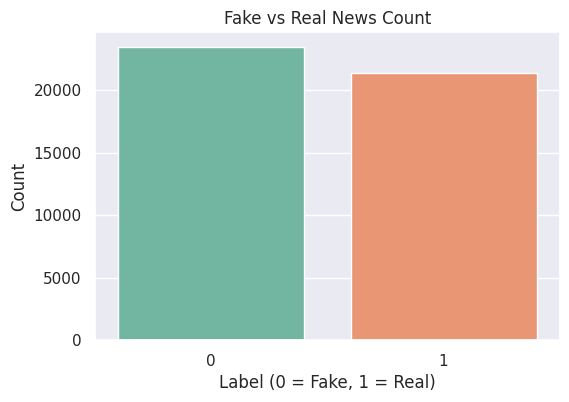

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="darkgrid")

# Plot count of fake (0) and real (1)
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data, palette='Set2')
plt.title('Fake vs Real News Count')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()


Data Cleaning

In [8]:
import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # lowercase
    text = "".join([char for char in text if char not in string.punctuation])  # remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # remove stopwords
    return " ".join(words)

data['clean_text'] = data['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


WordCloud for Fake vs Real News

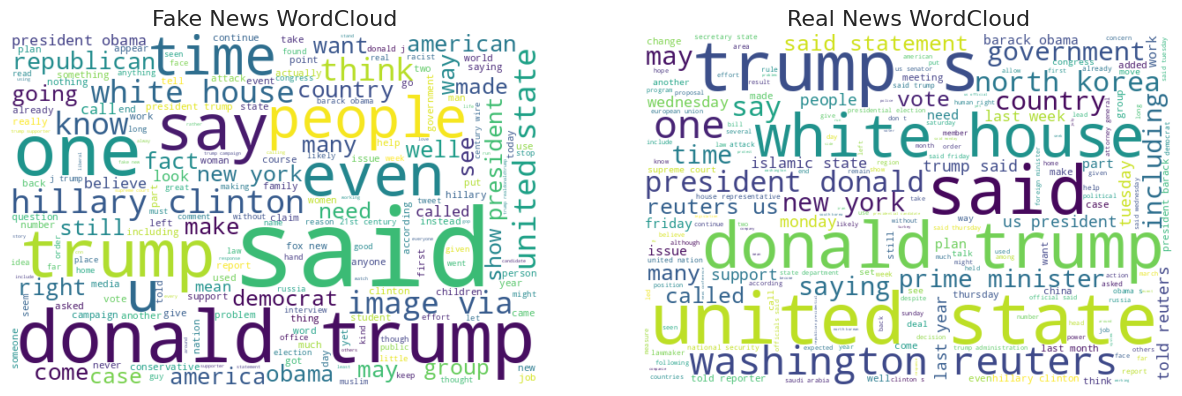

In [9]:
from wordcloud import WordCloud

# Generate WordCloud for Fake News
fake_words = " ".join(data[data['label'] == 0]['clean_text'])

# Generate WordCloud for Real News
real_words = " ".join(data[data['label'] == 1]['clean_text'])

# Plot side-by-side
plt.figure(figsize=(15,7))

plt.subplot(1, 2, 1)
wordcloud_fake = WordCloud(width=600, height=400, background_color='white').generate(fake_words)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title("Fake News WordCloud", fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_real = WordCloud(width=600, height=400, background_color='white').generate(real_words)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title("Real News WordCloud", fontsize=16)
plt.axis('off')

plt.show()


Text Tokenization + Padding for LSTM

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Use cleaned text
texts = data['clean_text'].values

# Set the maximum number of words (vocab size)
max_words = 5000

# Set the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

# Convert text to sequence of integers
sequences = tokenizer.texts_to_sequences(texts)

# Set max length of sequences (based on average text length)
maxlen = 300
X = pad_sequences(sequences, maxlen=maxlen)

# Labels
y = data['label'].values

# Shape check
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (44898, 300)
y shape: (44898,)


Train-Test Split + LSTM Model Building

In [12]:
#Split the data
from sklearn.model_selection import train_test_split

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (35918, 300)
Testing shape: (8980, 300)


In [13]:
#Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=300))  # vocab size = 5000
model.add(LSTM(units=64, return_sequences=False))  # LSTM layer
model.add(Dropout(0.5))  # prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # output layer for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train the LSTM Model

In [14]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=(X_test, y_test))


Epoch 1/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 166s 290ms/step - accuracy: 0.9054 - loss: 0.2416 - val_accuracy: 0.9726 - val_loss: 0.0853
Epoch 2/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 195s 278ms/step - accuracy: 0.9797 - loss: 0.0671 - val_accuracy: 0.9784 - val_loss: 0.0675
Epoch 3/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 208s 289ms/step - accuracy: 0.9881 - loss: 0.0437 - val_accuracy: 0.9885 - val_loss: 0.0402
Epoch 4/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 157s 280ms/step - accuracy: 0.9910 - loss: 0.0324 - val_accuracy: 0.9733 - val_loss: 0.0816
Epoch 5/5
562/562 ━━━━━━━━━━━━━━━━━━━━ 202s 280ms/step - accuracy: 0.9893 - loss: 0.0396 - val_accuracy: 0.9903 - val_loss: 0.0332


Plot Accuracy and Loss Graphs

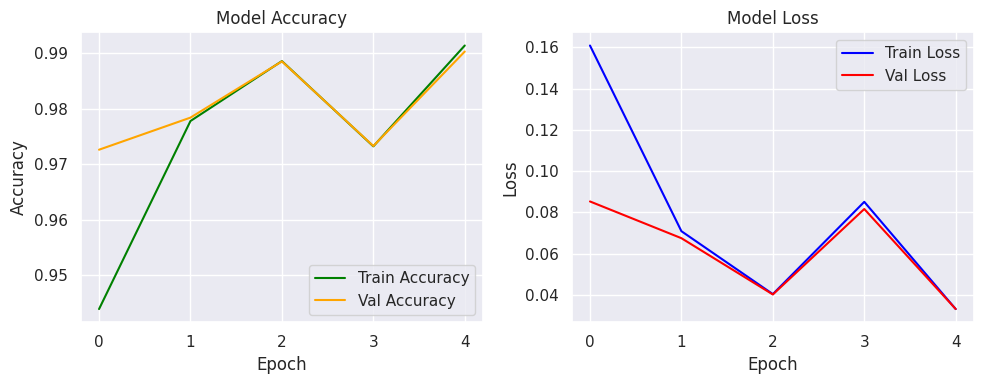

In [15]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Evaluate Model on Test Data

In [16]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", round(test_accuracy * 100, 2), "%")


281/281 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9895 - loss: 0.0330
Test Accuracy: 99.03 %


Classification Report & Confusion Matrix

281/281 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step


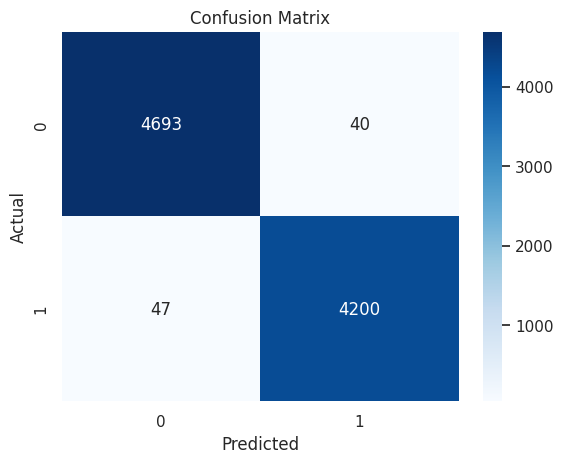

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4733
           1       0.99      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to 0 or 1

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred))
